In [1]:
import time
print(time.ctime(time.time()))

Wed Dec 10 20:31:16 2025


# Advent of Code Day 10

Puzzle text available at:
https://adventofcode.com/2025/day/10

NGL, had to check solutions for this one. Had the idea of to solve it but couldn't apply it correctly

In [2]:
import os
import re
import z3
import numpy as np
from itertools import combinations, pairwise
from IPython.display import Image, display, Markdown

In [3]:
# Day of calendar
day = 10
# Input filename
puzzle_test = 'input_day%02d_test.txt' %(day)
puzzle_input = 'input_day%02d.txt' %(day)

In [4]:
with open(puzzle_input, 'r') as f:
    lines = f.readlines() 
lights = []
buttons = []
joltage = []
for line in lines:
    bracket = re.search(r'\[(.*?)\]', line).group(1)
    lights.append([c == '#' for c in bracket])
    buttons.append([tuple(map(int, m.split(','))) for m in re.findall(r'\(([^)]+)\)', line)])
    joltage.append(list(map(int, re.search(r'\{([^}]+)\}', line).group(1).split(','))))

## Part 1

Find the fewest combination of buttons required to botain the desired configutation of lights

In [5]:
def solve_lights_minimal(buttons, target):
    m = len(buttons)  # number of buttons available
    n = len(target)   # number of lights
    
    # Build coefficient matrix A (n×m)
    # A[i,j] = 1 means button j toggles light i
    A = np.zeros((n, m), dtype=int)
    for j, button in enumerate(buttons):
        for pos in button:
            A[pos, j] = 1
    
    b = np.array(target, dtype=int)  # target state as binary vector

    # Find solution with minimum button presses
    min_solution = None
    min_count = float('inf')
    
    # Loop through all possible combinations of pressing or not pressing each button (2^m combinations)
    for mask in range(2**m):
        # Decode which buttons to press from the combination number
        # mask in binary represents which buttons to press (1) or not (0)
        x = np.array([(mask >> i) & 1 for i in range(m)])

        # Simulate pressing those buttons:
        # A @ x counts how many times each light is toggled
        # % 2 because: even toggles = off (0), odd toggles = on (1)
        final_state = (A @ x) % 2

        # If the final state matches our target, save this solution
        if np.all(final_state == b):
            count = np.sum(x)  # how many buttons we pressed
            # Only keep it if it's better (fewer presses) than previous solutions
            if count < min_count:
                min_count = count
                min_solution = [i for i in range(m) if x[i]]
    
    return min_solution

In [6]:
result_part_1 = 0
for switches, target in zip(buttons,lights):
    result_part_1 += len(solve_lights_minimal(switches, target))

In [7]:
print("What is the fewest button presses required to correctly configure the indicator lights on all of the machines?")
print(int(result_part_1))

What is the fewest button presses required to correctly configure the indicator lights on all of the machines?
571


# Part 2

Here we will be using the Z3 solver

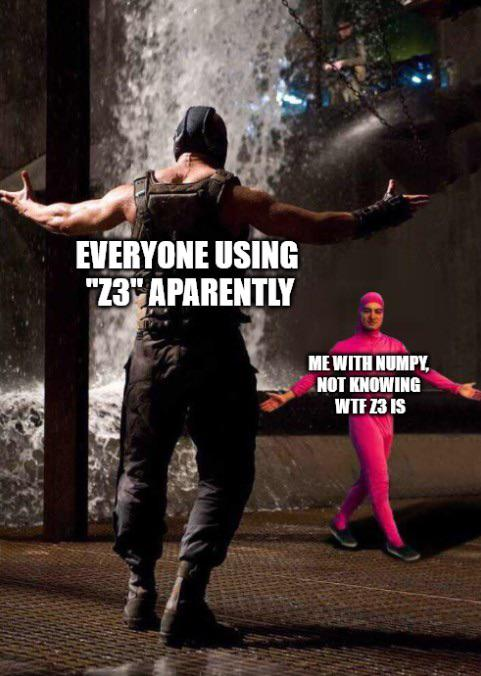

**Definitely not me using Z3 for the first time in my life**

In [8]:
display(Image('Z3_meme.jpeg'))
Markdown("**Definitely not me using Z3 for the first time in my life**")

### Why Z3 is Perfect for This?
- Handles integer constraints naturally - No rounding issues
- Built-in optimization - Automatically finds minimum
- Efficient - Uses advanced SAT/SMT algorithms under the hood
- Readable code - Constraints look like math equations
- Handles infeasibility - Returns unsat if no solution exists

### Key Z3 Functions Highlighted:

- z3.Int(name) - Creates an integer variable
- z3.Optimize() - Creates an optimizer (can minimize/maximize)
- optimizer.add(constraint) - Adds a constraint
- z3.Sum(list) - Sums a list of Z3 expressions
- optimizer.minimize(expr) - Sets minimization objective
- optimizer.check() - Solves and returns z3.sat/z3.unsat/z3.unknown
- optimizer.model() - Gets the solution (variable assignments)
- model[variable] - Gets value assigned to a variable
- .as_long() - Converts Z3 integer to Python int

In [9]:
def solve_joltage_z3(buttons, target):
    """
    Find minimum button presses to reach target counter values using Z3.
    
    Args:
        buttons: List of tuples, e.g., [(3,), (1,3), (2,), ...]
                 Each tuple indicates which counters that button affects
        target: List of target values for each counter, e.g., [3, 5, 4, 7]
    
    Returns:
        presses: List of how many times to press each button
        total: Total number of button presses (minimum)
    """
    m = len(buttons)  # number of buttons available
    n = len(target)   # number of counters to configure

    ### Create Z3 Integer Variables (Decision Variables)
    # z3.Int(name) creates an integer variable that Z3 will solve for
    # We create one variable for each button: x[i] = "times to press button i"
    x = [z3.Int(f'button_{i}') for i in range(m)]
    

    ### Create Z3 Optimizer
    # z3.Optimize() creates an optimizer that can minimize/maximize objectives
    # (Different from z3.Solver() which just finds any satisfying solution)
    optimizer = z3.Optimize()
    

    ### Add Constraints
    # --- Constraint a: Non-negativity ---
    # We can't press a button a negative number of times
    # optimizer.add() adds a constraint that must be satisfied
    for i in range(m):
        optimizer.add(x[i] >= 0)  # Each button press count must be >= 0
    
    # --- Constraint b: Counter targets ---
    # Each counter must reach exactly its target value
    # We need to sum up contributions from all buttons affecting each counter
    for counter_idx in range(n):
        # Build a list of contributions to this specific counter
        contributions = []
        
        # Check each button to see if it affects this counter
        for button_idx in range(m):
            # If counter_idx is in buttons[button_idx], this button affects it
            if counter_idx in buttons[button_idx]:
                # When we press button button_idx x[button_idx] times,
                # it adds x[button_idx] to counter counter_idx
                contributions.append(x[button_idx])
        
        # Add constraint: sum of contributions == target value
        if contributions:
            # z3.Sum(list) sums all elements in the list
            # This creates the constraint: contributions[0] + contributions[1] + ... == target
            optimizer.add(z3.Sum(contributions) == target[counter_idx])
        else:
            # Edge case: no button affects this counter
            # So target must be 0 for a solution to exist
            optimizer.add(target[counter_idx] == 0)
    

    ### Set Optimization Objective
    # optimizer.minimize(expr) tells Z3 to find the solution that minimizes expr
    # We want to minimize the total number of button presses
    total_presses = z3.Sum(x)  # z3.Sum(x) = x[0] + x[1] + x[2] + ... + x[m-1]
    optimizer.minimize(total_presses)
    
    ### Solve and Extract Solution
    # optimizer.check() attempts to find a solution
    # Returns: z3.sat (satisfiable - solution found)
    #          z3.unsat (unsatisfiable - no solution exists)
    #          z3.unknown (couldn't determine)
    if optimizer.check() == z3.sat:
        # Solution found!
        
        # optimizer.model() returns the model (assignment of values to variables)
        model = optimizer.model()
        
        # Extract the value Z3 assigned to each button press variable
        # model[x[i]] gets the value assigned to variable x[i]
        # .as_long() converts Z3's integer type to Python int
        presses = [model[x[i]].as_long() for i in range(m)]
        
        # Calculate total (could also use model.eval(total_presses).as_long())
        total = sum(presses)
        
        return presses, total
    else:
        # No solution exists (constraints are unsatisfiable)
        return None, None

In [10]:
result_part_2 = 0
for switches, jolt in zip(buttons,joltage):
    presses, total = solve_joltage_z3(switches, jolt)
    result_part_2 += total

In [11]:
print("What is the fewest button presses required to correctly configure the joltage level counters on all of the machines?")
print(int(result_part_2))

What is the fewest button presses required to correctly configure the joltage level counters on all of the machines?
20869
